# Chapter 6 - Using gate-based Quantum Computers - Some basic quantum algorithms 
1. Representation of qubits, matrix math and Bloch Sphere

© 2021, 2022 Packt Publishing

Written by Alex Khan

In [3]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [2]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [5]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [6]:
### Please run available_devices() and correct any device names below

def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system6.1','Advantage_system4.1','DW_2000Q_6','Aspen-M-1','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [7]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [8]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [9]:
# this function has been updated with an additional display_binary flag
def run_circuit(device, circuit, shots, s3_folder, display_binary=True):
    import matplotlib.pyplot as plt
    %matplotlib inline
    result = device.run(circuit, shots=shots, s3_destination_folder=s3_folder).result()
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [87]:
def draw_bloch(q):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")

    print('Matrix:')
    print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    print(' ')
    print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
    print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    print('Bloch Sphere:')
    plt.show()
    return(q)

In [88]:
def draw_circuit(circ):
    circ=circ.state_vector()

    print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r)

### 1. Representing qubits in matrix math and Bloch Sphere

In [89]:
import numpy as np

In [90]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])


$|0\rangle = 
\left[\begin{array}{cc} 
1 \\ 
0
\end{array}\right]$

Matrix:
[[1.+0.j]
 [0.+0.j]]
 
State Vector: |psi> = sqrt( [1.] ) |0> + ( sqrt( [0.] )) e^i [0.] pi |1>
 
Bloch Sphere:


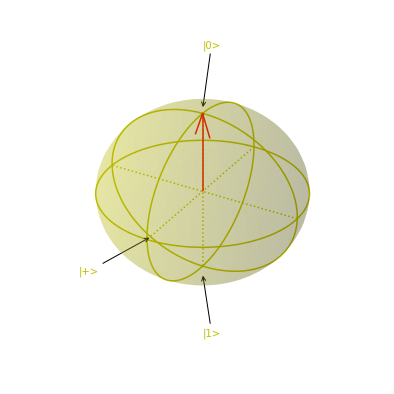

array([[1.+0.j],
       [0.+0.j]])

In [91]:
draw_bloch(arr_0)

In [29]:
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])

Matrix:
[[0.+0.j]
 [1.+0.j]]
 
State Vector: |psi> = sqrt( [0.] ) |0> + ( sqrt( [1.] )) e^i [0.] pi |1>
 
Bloch Sphere:


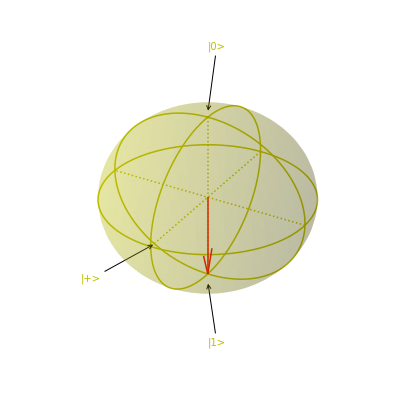

array([[0.+0.j],
       [1.+0.j]])

In [30]:
draw_bloch(arr_1)

In [ ]:
# i operator
arr_i=np.array([[1,0],[0,1]])

Matrix:
[[1.+0.j]
 [0.+0.j]]
 
State Vector: |psi> = sqrt( [1.] ) |0> + ( sqrt( [0.] )) e^i [0.] pi |1>
 
Bloch Sphere:


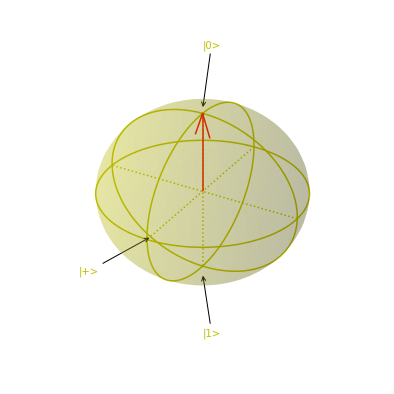

In [19]:
draw_bloch(arr_i @ arr_0)

In [ ]:
# x operator
arr_x=np.array([[0,1],[1,0]])

Matrix:
[[0.+0.j]
 [1.+0.j]]
 
State Vector: |psi> = sqrt( [0.] ) |0> + ( sqrt( [1.] )) e^i [0.] pi |1>
 
Bloch Sphere:


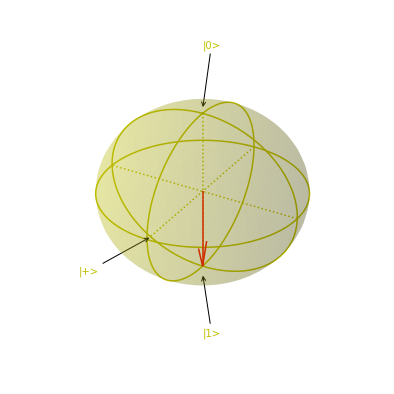

In [20]:
draw_bloch(arr_x @ arr_0)

In [33]:
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

Hadamard on $|0\rangle$ state

$$
\left[\begin{array}{cc} 
0.7071 & 0.7071\\
0.7071 & -0.7071
\end{array}\right]
\left[\begin{array}{cc} 
1 \\ 
0
\end{array}\right]
=
\left[\begin{array}{cc} 
0.7071 \\ 
0.7071
\end{array}\right]
$$ 

Matrix:
[[0.70710678+0.j]
 [0.70710678+0.j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [0.] pi |1>
 
Bloch Sphere:


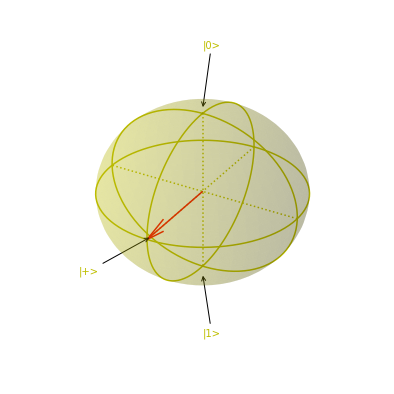

array([[0.70710678+0.j],
       [0.70710678+0.j]])

In [34]:
draw_bloch(arr_h @ arr_0)

In [35]:
arr_plus=arr_h @ arr_0
print(arr_plus)

[[0.70710678+0.j]
 [0.70710678+0.j]]


Matrix:
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [1.] pi |1>
 
Bloch Sphere:


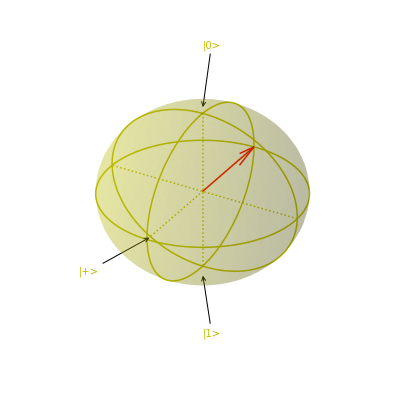

In [36]:
arr_minus=draw_bloch(arr_z @ arr_plus)

Matrix:
[[ 0.70710678+0.j ]
 [-0.5       -0.5j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [-0.75] pi |1>
 
Bloch Sphere:


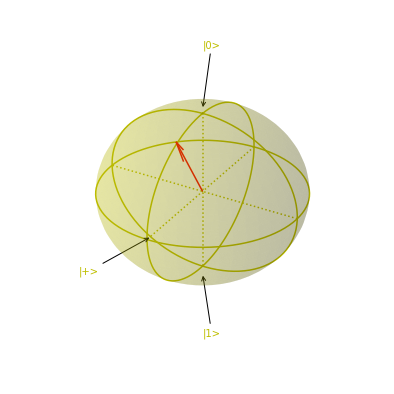

In [37]:
arr_r=draw_bloch(arr_t @ arr_minus)

In [ ]:
*** END HERE ****